**Task**

    Process numpy arrays in parallel
    
**Solution**

    dask

Geophysical models get higher and higher resolutions, producing more and more data. However numpy arrays and pandas data frames only work with data that fit in to a memory. For many of us it means that before real analysis we have to somehow subsample or aggregate initial data with some heavy lifting tools (like [cdo](https://code.azmaw.de/projects/cdo/embedded/index.html)) and only then switch to convenience and beauty of python. These times might come to an end soon with introduction of [dask](http://dask.pydata.org/en/latest/) - library that helps to parallelize computations on big chunks of data. This allows analyzing data that do not (or barely) fit in to your computer's memory as well as to utilize multiprocessing capabilities of your machine.

Below I will briefly describe dask arrays and show results of some simple benchmarks.


##Instllation:

###dask

If you don't use [conda](http://conda.pydata.org/miniconda.html), it's time to start now. This will install dask and some additional libraries that allow visualization of dask task graphs.

    conda install dask pydot networkx

If you still prefer pip:

    pip install dask[array]

should do the trick, but I am not sure if the visualization will work

###cdo

If you use Ubuntu 14.04, don’t install cdo from `apt-get`, they are compiled without netCDF4 support. Instructions of how to do it properly can be found [here](http://nbviewer.ipython.org/github/koldunovn/nk_public_notebooks/blob/master/Install%20climate%20data%20operators%20%28cdo%29%20on%20Ubuntu%20with%20netCDF4%20and%20hdf5%20support.ipynb). I am not sure if the problem appears also in the latest versions of Ubuntu. 

Mac users should be able to install them with:

    brew install cdo


Necessary imports

In [2]:
import os
import dask.array as da
from netCDF4 import Dataset
from IPython.display import Image

##Download the data

As usual I am going to use [good old NCEP reanalysis surface temperature data](http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.surface.html). This time we need to download all years and then merge them together in one file with cdo. Uncomment the code below to do so:

In [ ]:
#for y in range(1948,2015):
#    print(y)
#    os.system('wget ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis/surface/air.sig995.{}.nc'.format(str(y)))

#!cdo mergetime air.sig995.*.nc ncep_temperature.nc

##Small file

First just let’s play with a small file that easily fits in to the memory. My test computer is a 5-year-old machine with only 3Gb of memory and 2 cores. No SSD, just usual classical hard drive. 

We are going to calculate overall mean for one year. This file is about 22 Mb, but array in memory will occupy about 60 Mb (due to netCDF4 compression). There are 4 time steps a day (1464 in total) and 73x144 points in every field.


In [5]:
f = Dataset('air.sig995.1948.nc')
air = f.variables['air'][:]

In [6]:
air.nbytes

61558272

In [7]:
air.shape

(1464, 73, 144)

In [8]:
f.close()

**numpy.array**

This is our usual way with numpy array. Open the file, load the data, calculate the mean:


In [10]:
%%timeit
f = Dataset('air.sig995.1948.nc')
numpyresult = f.variables['air'][:].mean()
f.close()

1 loops, best of 3: 844 ms per loop


**cdo**

Same thing with cdo for comparison

In [11]:
%%timeit
!cdo -s fldmean -timmean air.sig995.1948.nc t.nc

1 loops, best of 3: 857 ms per loop


**dask.array**

And finally dask arrays:

In [12]:
%%timeit
f = Dataset('air.sig995.1948.nc')
daskarray = da.from_array(f.variables['air'], chunks=(500,73,144))
daskresult = daskarray.mean().compute()                   
f.close()

1 loops, best of 3: 723 ms per loop


Seems to be just a tiny bit faster, but not significantly. Let's stop here and have a look at what we did. Before doing any calculations we construct a dask array with `from array` method using handler for netCDF variable. As an additional parameter we provide `chunks`, that indicate the way of how we split our array in to parts. Then we create  `daskresult` variable by specifying some operation (`mean` in our case) on `daskarray` and calling `compute()`. The later executes the computation, but the interesting part is happening before. Let's create `daskresult` without computing it:

In [56]:
f = Dataset('air.sig995.1948.nc')
daskarray = da.from_array(f.variables['air'], chunks=(500,73,144))
daskresult = daskarray.mean()

What is created is a recipe of how to perform your operation in parallel. It can be accessed with `.dask` attribute

In [57]:
daskresult.dask

{'x_129': <netCDF4.Variable at 0xac198adc>,
 ('x_129', 0, 0, 0): (<function dask.array.core.getarray>,
  'x_129',
  (slice(0, 500, None), slice(0, 73, None), slice(0, 144, None))),
 ('x_129', 1, 0, 0): (<function dask.array.core.getarray>,
  'x_129',
  (slice(500, 1000, None), slice(0, 73, None), slice(0, 144, None))),
 ('x_129', 2, 0, 0): (<function dask.array.core.getarray>,
  'x_129',
  (slice(1000, 1464, None), slice(0, 73, None), slice(0, 144, None))),
 ('x_130', 0, 0, 0): (<functools.partial at 0xab00d6bc>, ('x_129', 0, 0, 0)),
 ('x_130', 1, 0, 0): (<functools.partial at 0xab00d6bc>, ('x_129', 1, 0, 0)),
 ('x_130', 2, 0, 0): (<functools.partial at 0xab00d6bc>, ('x_129', 2, 0, 0)),
 ('x_131',): (<toolz.functoolz.Compose at 0xaaebd0d4>,
  [[[('x_130', 0, 0, 0)]], [[('x_130', 1, 0, 0)]], [[('x_130', 2, 0, 0)]]])}

In this form it is not crystal clear, so let's put it in to a graph:

Writing graph to mydask.pdf


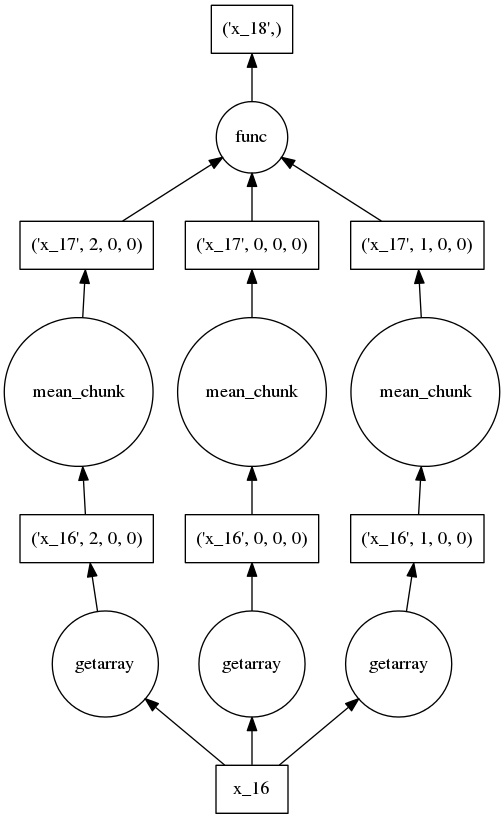

In [27]:
daskresult._visualize()
Image(filename='mydask.png',width=300)

You should read it from the bottom to the top: initial array is splitted into three parts (remember our `chunks` size), then mean is performed for each of this parts (in parallel) and then results are finally composed in to one number. What happen when you call `compute()` is this recipe gets executed by [dask own parallel scheduler](http://dask.pydata.org/en/latest/shared.html). However you can write your own scheduler that is better for your specific task or system.

Calculation of the total mean was sort of a trivial task, but when you do something a bit trickier, your recipes become more complicated:

Writing graph to mydask.pdf


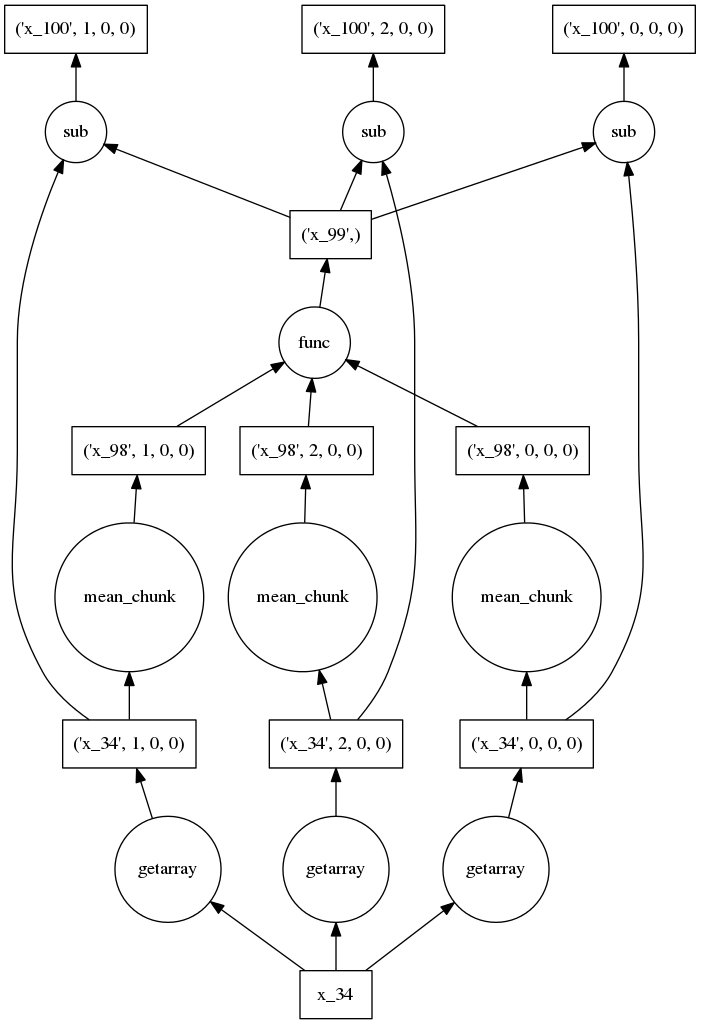

In [51]:
(daskarray - daskarray.mean())._visualize()
Image(filename='mydask.png',width=300)

Or you can get even more wild:

Writing graph to mydask.pdf


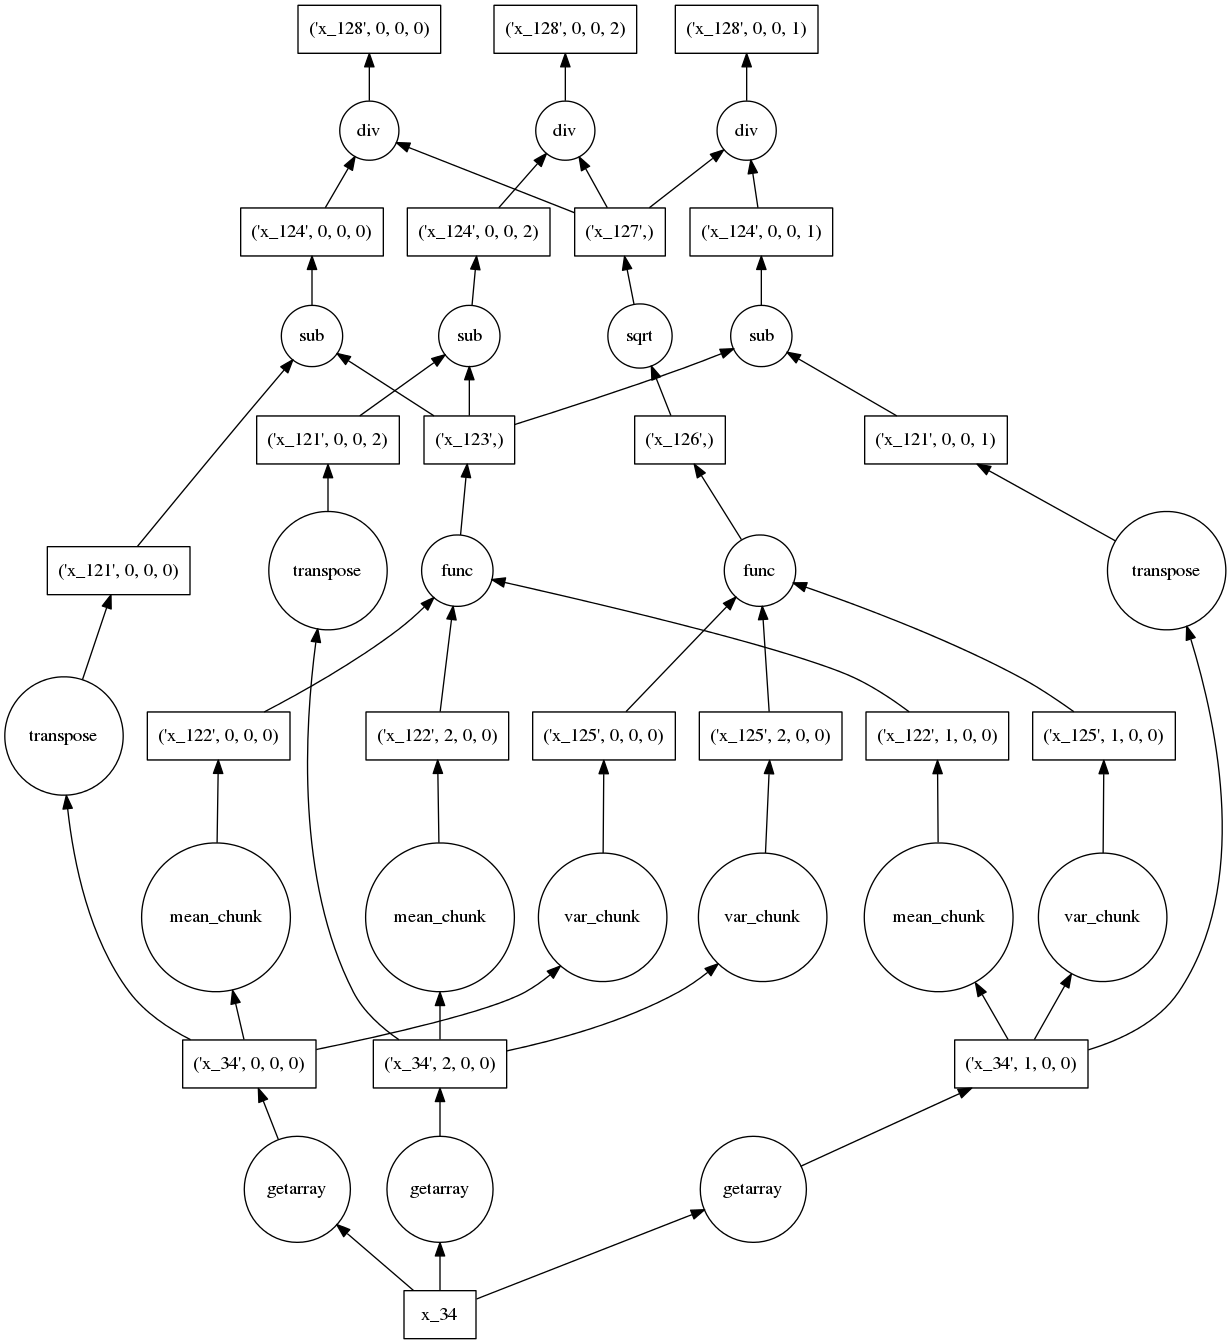

In [55]:
((daskarray.T - daskarray.mean())/daskarray.std())._visualize()
Image(filename='mydask.png',width=400)

So in essence dask allows you to create the task graph, which then can be executed by the parallel scheduler (from dask or from you).

Or you can think of dask as of just a faster way to do your numpy.array operation :)


##File that do not fit in to the memory

Here I just going to show results that I get with dask on my relatively old computer with the file that does not fit in to the memory (it's about 4 Gb, I have only 3 Gb). What you should look at is only `Wall time`, for cdo `CPU times` doesn’t make sense.

Here we just compute overall mean

**numpy.array**

Didn't even try to compute, immediately rise MemoryError

In [10]:
#%%timeit
#f = Dataset('ncep_temperature.nc')
#numpyresult = f.variables['air'][:].mean()
#f.close()

**cdo**

In [59]:
%%time
!cdo -s fldmean -timmean ./ncep_temperature.nc t.nc

CPU times: user 236 ms, sys: 52 ms, total: 288 ms
Wall time: 51.8 s


**dask.array**

In [60]:
%%time
f = Dataset('ncep_temperature.nc')
daskarray = da.from_array(f.variables['air'], chunks=(5000,73,144))
daskresult = daskarray.mean().compute()                   
f.close()

CPU times: user 15.4 s, sys: 11.3 s, total: 26.7 s
Wall time: 48.3 s


A bit faster, but not very impressive. Let's try something a bit more complicated - std:

**cdo**

In [61]:
%%time
!cdo -s timstd ./ncep_temperature.nc t.nc

CPU times: user 356 ms, sys: 64 ms, total: 420 ms
Wall time: 1min 36s


**dask.array**

In [62]:
%%time
f = Dataset('ncep_temperature.nc')
daskarray = da.from_array(f.variables['air'], chunks=(5000,73,144))
daskresult = daskarray.std(axis=0).compute()                   
f.close()

CPU times: user 23.1 s, sys: 14.3 s, total: 37.4 s
Wall time: 1min 2s


This is already something - more than 1.5 times faster. How about creating global mean for every time step?

In [63]:
%%time
!cdo -s fldmean ./ncep_temperature.nc t.nc

CPU times: user 368 ms, sys: 68 ms, total: 436 ms
Wall time: 1min 37s


In [6]:
%%time
f = Dataset('ncep_temperature.nc')
daskarray = da.from_array(f.variables['air'], chunks=(5000,73,144))
daskresult = daskarray.mean(axis=(1,2)).compute()                   
f.close()

CPU times: user 17.4 s, sys: 13.3 s, total: 30.7 s
Wall time: 1min 5s


Maybe not two times, but still about 30 seconds faster, and if you process a lot of files this might sum up in to some good hours :) 

I also have tried to do this test on a faster computer with many cores (24) and a lot of memory (256 Gb). Results are even more impressive. For some of the tests I was able to get more than 15 times faster speed compared with cdo. So even if your big arrays fit in to the memory, you can seriously benefit from parallel computations with dask.

Matthew Rocklin, lead developer of dask, recently give a very [nice presentation at PyData Berlin](https://www.youtube.com/watch?v=HLME2WKTJJ8), it's really worth to watch if you are interested in dask.